## Analysis of pandemic dynamics assuming SIR-like evolution
### Carlos Ignacio Herrera-Nolasco$^{1}$, Marco Arieli Herrera-Valdez$^{1}$
#### $^{1}$ Laboratorio de Fisiología de Sistemas, Facultad de Ciencias, UNAM

Assume that the population is divided in three subsets representing the non-infected and susceptible, the infected, and those that can no-longer participate in the chain of infections due to immunity or death. Let the densities of those subpopulations be represented by $x$, $y$, and $z$ respectively, with $1=x+y+z$. The dynamics for $(x,y,z)$ can be assume to follow 
\begin{eqnarray}
\partial_t y &=& \beta y \bigg( 1- z - y \bigg) - y \bigg(\gamma + \delta \bigg)\\
\partial_t z &=& \left( \gamma + \delta \right)y
\end{eqnarray}


If $h$ is the time step for sampling, let $y_{n}$ represent the number of cases at time $t=nh$. From data, the cumulative number of cases at step $nh$ can be written as 
$$C_{n} = \sum_{k=0}^{n} y_k$$
which means that the number of new cases (incidence) at time nh is 
$$y_n = C_n - C_{n-1}.$$
Similarly, for the cumulative recoveries and deaths, respectively
$$R_{n}+D_{n} = \sum_{k=0}^{n} z_k,$$
so 
$$z_n = (R_{n}-R_{n-1})+(D_{n}-D_{n-1}).$$

From the SIR classical formulation, assuming $\gamma$ is the rate of removal by recovery and acquisition of immunity and $\delta$ is the fatality rate due to infection, the time dependent change in the prevalence is given by
\begin{eqnarray}
\partial_t y &=& y  \beta \big( 1- z - y  \big) - \partial_t z
\end{eqnarray}
with $z$ representing the sum of the recoveries and deaths at time $t= kh$.
The change in $y$ can then be written as 
$$\partial_t y =  \beta y \bigg( \alpha -z - y  \bigg), $$
with $$\alpha = 1 -\frac{\gamma + \delta}{\beta}.$$
This means that the incidence and the prevalence are related cuadratically in the $(y,\partial_t y)$ plane.
Using the data, the change in $y$ can be written as 
$$\frac{y_{k+1}-y_{k}}{h} \approx \beta y \bigg( \alpha -z - y \bigg),$$
which means that 
$$y_{k+1}-y_{k} \approx h \beta y \bigg( \alpha -z - y \bigg).$$

#### Parameters for modeling 
From the equation for $z$,
$$\gamma + \delta = \frac{\partial_t z}{y} \approx \frac{z_{k+1}-z_k}{h y_k}$$ 
Also, 
$$\beta = \frac{\partial_t y + \partial_t z}{y \bigg( 1 -z - y  \bigg)} $$ 
Then, loosely taking the approximations 
$$
\partial_t u \approx \frac{u(t+h)-u(t)}{h},  \quad u \in \left\{y,z \right\}
$$
into account, the parameters $\beta$, $\gamma$, $\delta$ can be estimated. 


In [1]:
import sys
sys.path.insert(1, '../')
from dam_COVID19_baseCode import *
import matplotlib.pylab as gr
small={'family' : 'normal','weight' : 'normal','size'   : 8}
medium={'family' : 'normal','weight' : 'normal','size'   : 10}
large={'family' : 'normal','weight' : 'bold','size'   : 13}
gr.rc('font', size=small['size'], weight='normal')          # controls default text sizes
gr.rc('axes', titlesize=medium['size'])     # fontsize of the axes title
gr.rc('axes', labelsize=medium['size'])    # fontsize of the x and y labels
gr.rc('xtick', labelsize=small['size'])    # fontsize of the tick labels
gr.rc('ytick', labelsize=small['size'])    # fontsize of the tick labels
gr.rc('legend', fontsize=small['size'])    # legend fontsize
gr.rc('figure', titlesize=large['size'])  # fontsize of the figure title
%matplotlib inline 

Data for Mexico obtained from http://187.191.75.115/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip
Data obtained from https://github.com/CSSEGISandData/COVID-19/


In [8]:
cases, deathCases,recovCases = getCSSEGISandData(urlData=1)
# ------------------------------
# Description of the data so that the headers and the columns
# without case data are distinguished
# ------------------------------
nRows,nCols=cases.shape
cases.head(10)
nHeaderRows=1;
#
nHeaderCols=3
# how to generate date lists from a baseline using the datetime
dates = cases.columns[4:]
nDays = len(dates)
days = np.arange(nDays)
print('Got data from %d days between %s and %s'%(nDays,dates[0],dates[-1]))
# -------------------
print("""""")
# -------------------
npCases = cases.to_numpy()
countries = np.unique(npCases[:,1])
nCountries = len(countries)
print('Considering data from {d} countries'.format(d=nCountries))
# -------------------
# Gather same country data
# -------------------
gCases, countries_Cases= sortDataByCountry(cases, nHeaderCols)
gDeaths,countries_DeathCases = sortDataByCountry(deathCases, nHeaderCols)
gRecovCases,countries_RecovCases = sortDataByCountry(recovCases, nHeaderCols)
# -------------------
# Sum the counts from each country and construct a new array
# -------------------
# These arrays have the same size as the countries array (unique countries)
totCases=gatherDataByCountry(df=cases,nHeaderCols=4)
totDeathCases=gatherDataByCountry(df=deathCases,nHeaderCols=4)
totRecovCases=gatherDataByCountry(df=recovCases,nHeaderCols=4)
# -------------------
# Search regions to illustrate the case-fatality ratios
# -------------------
Pops_Millions = {'Algeria':43851044, 'Argentina':45195774,'Australia':25499884,'Brazil':212559417, 
                 'Canada':37742154, 'China':1439323776, 'Colombia':50882891,'Egypt':102334404,
                 'France':67886011,'Germany':83783942, 'Japan':126476461,'Korea, South':51269185,
                 'Indonesia':273523615, 'Iran':83992949,'Israel':8655535,'Italy':60461826,
                 'Mexico':128932753, 'Niger':24206644, 'Singapore':5850342, 
                 'South Africa':59308690,'Spain':46754778,
                 'United Kingdom':67886011, 'US':331002651, 'Venezuela':28870195}

Got data from 96 days between 1/22/20 and 4/26/20

Considering data from 185 countries


#### Parabola describing the incidence as a function of the cases

In [9]:
#def casePhasePlane(b=50.0, cou='Italy'):
def casePhasePlane(cou='Italy',a=0.005,b=10):
    cInd = np.where(countries==cou)[0][0]
    tCases= np.float64(totCases[cInd,:])/Pops_Millions[cou]
    tDeaths=np.float64(totDeathCases[cInd,:])/Pops_Millions[cou]
    tRecovs=np.float64(totRecovCases[cInd,:])/Pops_Millions[cou]
    y = tCases - tRecovs - tDeaths
    z = tRecovs + tDeaths
    dz=np.zeros(len(z))
    dz[1:]= z[1:]-z[:1]
    dy = np.zeros(len(y))
    dy[1:]= y[1:]-y[:-1]
    gammaDelta = dz/y
    beta = (dy+dz)/((1-z-y)*y)
    a = a+z
    fy = b*y*(a-z-y) 
    #
    ff =gr.figure(figsize=(17,5)); gr.ioff(); rows=1; cols=3
    ax1= ff.add_subplot(rows,cols,1); tax1= ax1.twinx()
    ax2= ff.add_subplot(rows,cols,2); 
    ax3= ff.add_subplot(rows,cols,3); 
    ax1.plot(days, y,'o',markeredgecolor='blue', markerfacecolor='white',label=r'$y_k$')
    #ax1.plot(days, tCases,'.',label=r'$(k,C_k)$')
    tax1.plot(days, beta/gammaDelta,'.',label=r'$\beta/\gamma$')
    ax1.plot(days, tDeaths,'.',label=r'$D_k$')
    ax1.plot(days, tRecovs,'.',label=r'$R_k$')
    ax1.plot(days, z,'.',label=r'$z_k=D_k + R_k$')
    ax2.plot(dy,y,'o',markeredgecolor='blue', markerfacecolor='white',label=r'$(y_k - y_{k-1}, y)$')
    ax2.plot(fy,y,'.',color='orange',label=r'$(\beta (a-z-y)y,y)$')
    ax3.plot(1-z-y,y,'.',label=r'$(1-z-y, y)$')
    ax2.plot([0,0],[0,y.max()],'k:')
    ax1.set_ylim(0,1.1* y.max())
    ax2.set_ylim(0,1.1* y.max())    
    ax2.set_xlim(dy.min(),1.3*dy.max())
    ax1.set_xlabel(r'$t$ (days)');ax2.set_xlabel(r'$y_k - y_{k-1}$')
    ax1.set_ylabel(r'$y_k$');ax2.set_ylabel(r'$y_k$')
    ax2.legend(loc='lower right'); ax3.legend(loc='upper right'); 
    ax1.legend(loc='center left'); tax1.legend(loc='upper left')
    gr.ion(); gr.draw()
    ff.suptitle('Phase plane, %s'%cou)
    ff.subplots_adjust(left=0.075,bottom=0.075,right=0.9,top=0.92,wspace=0.2,hspace=0.25)
    ff.savefig('figures_COVID19_dataAnalysis/dam_COVID19_JHU_phasePlane+%s.png'%cou)
    return y, z, dy, dz, beta, gammaDelta, ff

def gammaDelta_Estimate(y, dz):
    return (dz/y)

def betaEstimate(y,z,dy, dz):
    return (dy+dz)/((1-z-y)*y)


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


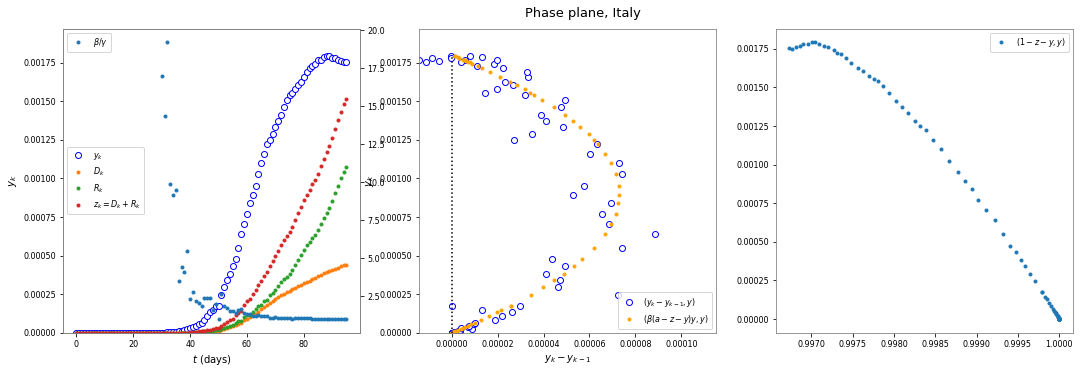

In [10]:
y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='Italy',a=0.0018,b=90)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in divide
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


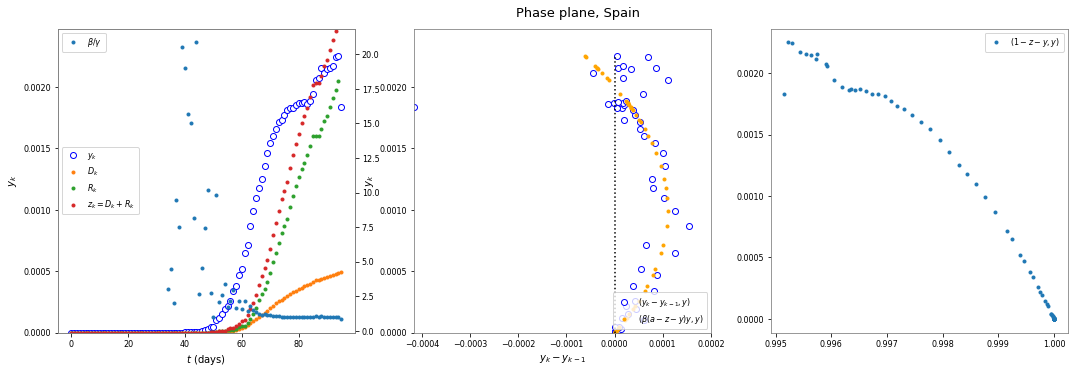

In [11]:
y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='Spain',a=0.002,b=110)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


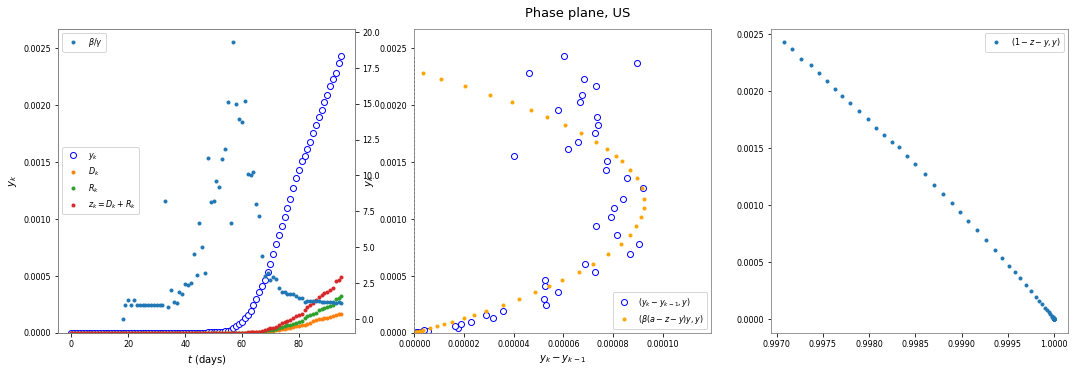

In [12]:
y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='US',a=0.0023,b=70)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


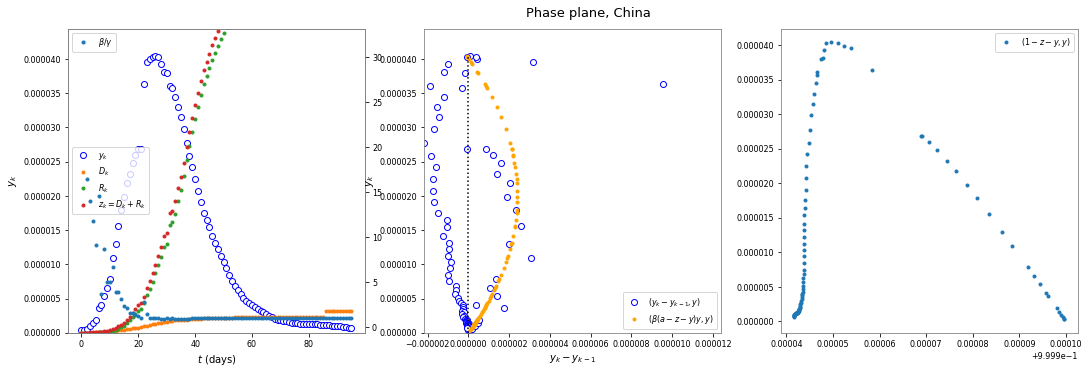

In [13]:
#y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='Italy',a=0.00175,b=90)
y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='China',a=0.00004,b=6000)
#print((1-y-z)*beta/gammaDelta )


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


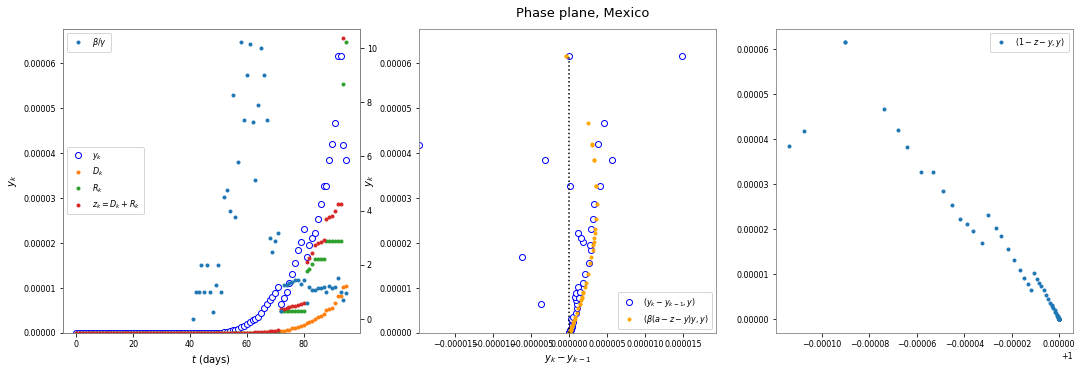

In [14]:
y,z, dy,dz,beta,gammaDelta,ff=casePhasePlane(cou='Mexico',a=0.00006,b=4000)